# Number of Messages Sent Factorial Analysis (Rectangular Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'messages.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = []
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Performance indexes
perfIndexes = [
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
#for intPercentile in intPercentiles:
    #vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    #transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)

if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

configsCount = int(scalars_wide['config'].max()) + 1
totalSims = configsCount*repetitionsCount
display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 100)

# coverage
#scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## Full factorial

In [9]:
for cfg in range(0, configsCount):
    for perfIndex, _ in perfIndexes:
        mean = scalars_wide[scalars_wide['config'] == cfg][perfIndex].mean()
        variance = scalars_wide[scalars_wide['config'] == cfg][perfIndex].var()
        _, positiveInterval = tuple(v*math.sqrt(variance/repetitionsCount) for v in stats.t.interval(tIntervalAlpha, repetitionsCount - 1))
        negerr = positiveInterval
        poserr = positiveInterval
        if perfIndex == 'coveredUsersPercent':
            poserr = min(1 - mean, positiveInterval)
        if perfIndex == 'Floorplan.msgsPerSlot:sum':
            userCount = scalars_wide['Floorplan.userCount'].max()
            poserr = min(userCount - mean, positiveInterval)
        scalars_wide.loc[scalars_wide['config'] == cfg, perfIndex + 'Mean'] = mean
        scalars_wide.loc[scalars_wide['config'] == cfg, perfIndex + 'Variance'] = variance
        scalars_wide.loc[scalars_wide['config'] == cfg, perfIndex + 'Negerr'] = negerr
        scalars_wide.loc[scalars_wide['config'] == cfg, perfIndex + 'Poserr'] = poserr
scalars_wide = scalars_wide[scalars_wide['repetition'] == 0]

for perfIndex, _ in perfIndexes:
    del scalars_wide[perfIndex]
del scalars_wide['repetition']
del scalars_wide['Floorplan.userCount']
#del scalars_wide['Floorplan.coveredUsers:sum']
del scalars_wide['config']

scalars_wide       

qname,R,T,m,Floorplan.msgsPerSlot:sumMean,Floorplan.msgsPerSlot:sumVariance,Floorplan.msgsPerSlot:sumNegerr,Floorplan.msgsPerSlot:sumPoserr
run,,,,,,,
RectangularMessages-0-20210609-16:48:44-24974,8.0,2.0,2.0,1379.6,156.933333,8.961493,8.961493
RectangularMessages-70-20210609-16:51:12-25436,8.0,2.0,3.0,1488.7,27.344444,3.740738,3.740738
RectangularMessages-140-20210609-16:56:14-26133,8.0,2.0,4.0,1492.0,10.000000,2.262157,2.262157
RectangularMessages-210-20210609-17:01:36-26872,8.0,2.0,5.0,1490.0,30.888889,3.975794,3.975794
RectangularMessages-280-20210609-17:06:38-27572,8.0,3.0,2.0,1316.8,203.288889,10.199517,10.199517
RectangularMessages-350-20210609-17:09:23-27949,8.0,3.0,3.0,1468.7,71.788889,6.061099,6.061099
RectangularMessages-420-20210609-17:14:10-28633,8.0,3.0,4.0,1489.0,44.444444,4.769046,4.769046
RectangularMessages-490-20210609-17:19:50-29447,8.0,3.0,5.0,1489.1,117.655556,7.759415,7.759415
RectangularMessages-560-20210609-17:25:12-30216,8.0,4.0,2.0,1290.2,153.955556,8.876065,8.876065


Plotting with R on the x axis...


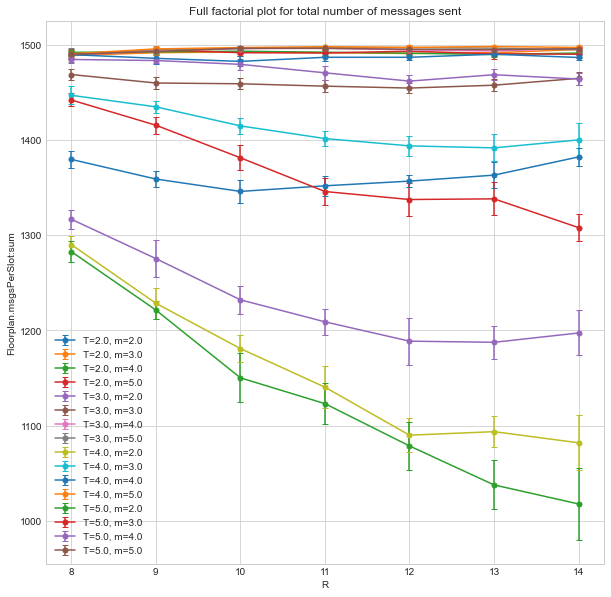

########################################

Plotting with T on the x axis...


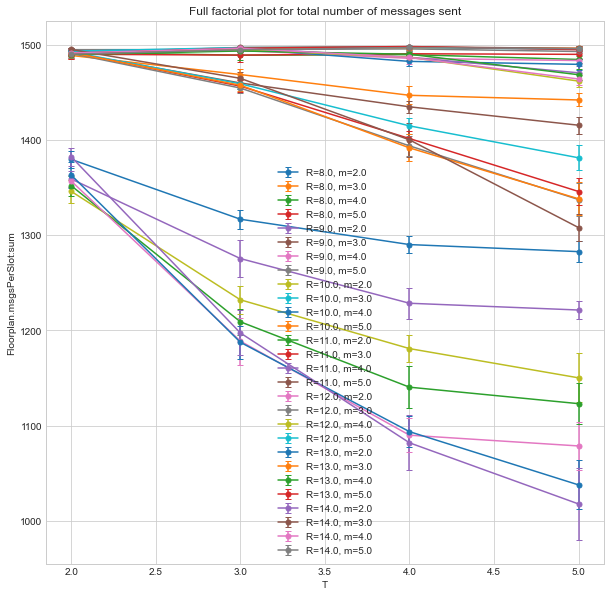

########################################

Plotting with m on the x axis...


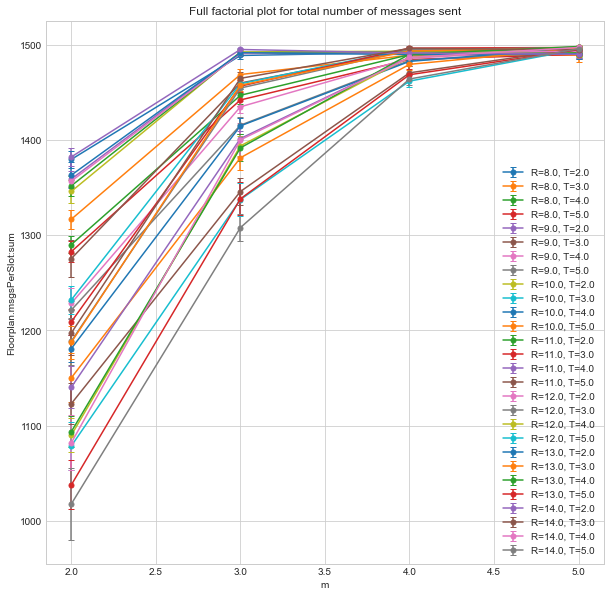

########################################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    otherFactors = [fac for fac in factors if fac != xFactor]
    current = scalars_wide.sort_values([xFactor, *otherFactors])
    count = 0
    lastVal = None
    for index,row in current.iterrows():
        if lastVal != None and lastVal != row[xFactor]:
            count = 0
        current.loc[index, 'config'] = count
        count += 1
        lastVal = row[xFactor]
    x = current[xFactor].unique().tolist()
    for perfIndex, perfIndexDesc in perfIndexes:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        for cfg in range(0, int(current['config'].max()) + 1):
            y = current[current['config'] == cfg][perfIndex + 'Mean'].tolist()
            poserr = current[current['config'] == cfg][perfIndex + 'Poserr'].tolist()
            negerr = current[current['config'] == cfg][perfIndex + 'Negerr'].tolist()
            realy = []
            realx = []
            realne = []
            realpe = []
            curIdx = 0
            for val in y:
                if not math.isinf(val):
                    realy.append(val)
                    realx.append(x[curIdx])
                    realne.append(negerr[curIdx])
                    realpe.append(poserr[curIdx])
                curIdx += 1
            y = realy
            negerr = realne
            poserr = realpe
            err = [negerr, poserr]
            lbl = ""
            for fac in otherFactors:
                lbl += fac + '=' + str(current[current['config'] == cfg][fac].tolist()[0]) + ', '
            lbl = lbl[:-2]
            plt.errorbar(x=np.array(realx), y=np.array(y), yerr=np.array(err), capsize=3, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Full factorial plot for ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.xlabel(xFactor)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-ffplot.png')
        plt.show()
    print('########################################')
    print()

## Observations

As in the low density scenario, increase the broadcast radius has great benefits only if combined with low value of max copies, but this have to be avoided for energy efficiency.
So the best way, which implies very good results, is to decrease `m`, which has a very great influence on the number of messages sent. Another possible way to have little improvements is to use high `T`

This is the only scenario without results with a very large variance in some experiments, so this seems to be a more stable scenario.